In [118]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# RDKit tools
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFMCS

# scipy hierarchy clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster, cophenet
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

# SKlearn metrics
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.neighbors import NearestCentroid

# Making plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
path = '/Users/hek/Research/Cheminformatics/Project_1_NPS/Stimulant vs. Hallucinogens/ChEMBL Dataset ML results/'

In [123]:
df = pd.read_csv(path+"Drugs Raman or SERS in literature _ Paper 1.csv")
print("Total number of unique NPS compounds:", df.shape[0])

Total number of unique NPS compounds: 189


In [124]:
df.head(2)

,Name,Other name,Formula,MW,CAS,PubChem CID,RotBondCount,Conformers,Canonical SMILES,Pharm class,Pharm target,Pharm class label,Chem core,InChI Key,StdInChI,canonical_smiles,maccsfp,morganfp,RF_morgan
0,Heroin,NaN,C21H23NO5,369.40,561-27-3,5462328,4,9.0,CC(=O)OC1C=CC2C3CC4=C5C2(C1OC5=C(C=C4)OC(=O)C)...,Depressants_Opioids,μ-opioid receptor,1,Alkaloid,GVGLGOZIDCSQPN-PVHGPHFFSA-N,InChI=1S/C21H23NO5/c1-11(23)25-16-6-4-13-10-15...,CC(=O)Oc1ccc2c3c1OC1C(OC(C)=O)C=CC4C(C2)N(C)CC...,0000000000000000000000000000000000000000000000...,0000000000010001000000000000000001001000000000...,0000000000000000000000000000000000000000000000...
1,Morphine,NaN,C17H19NO3,285.34,57-27-2,5288826,0,1.0,CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O,Depressants_Opioids,μ-opioid receptor,1,Alkaloid,BQJCRHHNABKAKU-KBQPJGBKSA-N,InChI=1S/C17H19NO3/c1-18-7-6-17-10-3-5-13(20)1...,CN1CCC23c4c5ccc(O)c4OC2C(O)C=CC3C1C5,0000000000000000000000000000000000000000000000...,0000000000000001000000000000000001001000000000...,0000000000000000000000000000000000000000000000...


##### Pharm class label assigned according to primarity mechanism of action.
##### This script is to assign common core structure based class label.

In [125]:
print(df["Pharm class"].unique())

['Depressants_Opioids' 'Stimulants' 'Cannabinoids'
 'Serotonergic psychedelics' 'Depressants_Benzodiazepines']


### Calculate Affinity matrix for clustering

#### I. Calculate MCS Tanimoto
* Without include H atoms
* Add H atoms

In [126]:
def tanimoto_mcs(smi1,smi2):
    #reading smiles of two molecules and create molecule
    m1 = Chem.MolFromSmiles(smi1)
    m2 = Chem.MolFromSmiles(smi2)
    mols = [m1, m2]
    
    #number heavy atoms of both molecules
    a = m1.GetNumAtoms()
    b = m2.GetNumAtoms()
    #print(a,b)
    #find heavy atoms in MCS
    r = rdFMCS.FindMCS(mols,ringMatchesRingOnly=True,bondCompare=Chem.rdFMCS.BondCompare.CompareAny,
                   atomCompare=rdFMCS.AtomCompare.CompareAny,timeout=1)
    c = r.numAtoms
    #print(c)
    if (c < 0):
        c = 0
    mcs_tani = c/(a+b-c)
    #get MCS smart
    #mcs_sm = r.smartsString
    #print(mcs_sm)
    return mcs_tani

In [127]:
def tanimoto_mcs_withH(smi1,smi2):
    #reading smiles of two molecules and create molecule
    m1 = Chem.MolFromSmiles(smi1)
    m2 = Chem.MolFromSmiles(smi2)
    
    m1H = Chem.AddHs(m1)
    m2H = Chem.AddHs(m2)
    mols = [m1H, m2H]

    #number heavy atoms of both molecules
    a = m1H.GetNumAtoms()
    b = m2H.GetNumAtoms()
    #print(a,b)
    #find heavy atoms in MCS
    r = rdFMCS.FindMCS(mols,ringMatchesRingOnly=True,bondCompare=Chem.rdFMCS.BondCompare.CompareAny,
                   atomCompare=rdFMCS.AtomCompare.CompareAny,timeout=1)
    c = r.numAtoms
    #print(c)
    if (c < 0):
        c = 0
    mcs_tani = c/(a+b-c)
    #get MCS smart
    #mcs_sm = r.smartsString
    #print(mcs_sm)
    return mcs_tani

#### III. Tanimoto matrix for hierarchical clustering and heatmap

In [128]:
list_len = df.shape[0]
test_cid_1 = list(df['Name'])
test_cid_1 = test_cid_1[0:list_len]
test_cid_2 = test_cid_1

##### MCS Tanimoto 

* Heavy atom only: tanimoto_mcs(smi1,smi2)
* All atoms: tanimoto_mcs_withH

In [130]:
df_cid = pd.DataFrame(0,index=test_cid_1,columns=test_cid_2)

df_pair = pd.DataFrame(0,index=test_cid_1,columns=['Pair','MaxValue'])

for i,cid_1 in enumerate(test_cid_1):
    print(i)
    if i%10 == 0:
        print(i*100/df.shape[0],'%')
    for j,cid_2 in enumerate(test_cid_2):
        #print(j)
        df_cid.loc[cid_1,cid_2] = tanimoto_mcs(df.loc[i,'canonical_smiles'], df.loc[j,'canonical_smiles'])
    tmpInd = df_cid.loc[cid_1,cid_1 != df_cid.columns].idxmax()
    tmpValue = df_cid.loc[cid_1,tmpInd]
    df_pair.loc[cid_1,'Pair'] = tmpInd
    df_pair.loc[cid_1,'MaxValue'] = tmpValue
    
df_pair = df_pair.reset_index()

0
0.0 %
1
2
3
4
5
6
7
8
9
10
5.291005291005291 %
11
12
13
14
15
16
17
18
19
20
10.582010582010582 %
21
22
23
24
25
26
27
28
29
30
15.873015873015873 %
31
32
33
34
35
36
37
38
39
40
21.164021164021165 %
41
42
43
44
45
46
47
48
49
50
26.455026455026456 %
51
52
53
54
55
56
57
58
59
60
31.746031746031747 %
61
62
63
64
65
66
67
68
69
70
37.03703703703704 %
71
72
73
74
75
76
77
78
79
80
42.32804232804233 %
81
82
83
84
85
86
87
88
89
90
47.61904761904762 %
91
92
93
94
95
96
97
98
99
100
52.91005291005291 %
101
102
103
104
105
106
107
108
109
110
58.2010582010582 %
111
112
113
114
115
116
117
118
119
120
63.492063492063494 %
121
122
123
124
125
126
127
128
129
130
68.78306878306879 %
131
132
133
134
135
136
137
138
139
140
74.07407407407408 %
141
142
143
144
145
146
147
148
149
150
79.36507936507937 %
151
152
153
154
155
156
157
158
159
160
84.65608465608466 %
161
162
163
164
165
166
167
168
169
170
89.94708994708995 %
171
172
173
174
175
176
177
178
179
180
95.23809523809524 %
181
182
183
184

In [132]:
df_cid.head(2)

,Heroin,Morphine,Acetylcodeine,Codeine,Hydrocodone,Oxycodone,Hydromorphone,Oxymorphone,Naltrexone,Naloxone,...,Clobazam,Nordazepam,Fludiazepam,Flubromazepam,Phenazepam,Meclonazepam,Clonazolam,Pyrazolam,Flubromazolam,Etizolam
Heroin,1.000000,0.777778,0.925926,0.814815,0.814815,0.785714,0.777778,0.750000,0.677419,0.758621,...,0.411765,0.393939,0.411765,0.382353,0.382353,0.428571,0.485714,0.484848,0.470588,0.470588
Morphine,0.777778,1.000000,0.840000,0.954545,0.954545,0.913043,1.000000,0.954545,0.840000,0.875000,...,0.500000,0.481481,0.500000,0.464286,0.464286,0.466667,0.533333,0.592593,0.571429,0.517241


In [133]:
df_cid.to_csv(output_path+"NPS compounds MCS Tanimoto matrix - Unique compounds.csv")
df_pair.to_csv(output_path+"NPS compounds MCS Tanimoto nearest neighbor - Unique compounds.csv")

### Hierarchical clustering and calculate ARI and NMI using the external class label

In [134]:
# only heavy-atom MCS
MCS = pd.read_csv(output_path+"NPS compounds MCS Tanimoto matrix - Unique compounds.csv",index_col="Unnamed: 0")
# all-atom MCS
#AA_MCS = pd.read_csv(output_path+"NPS compounds all-atom MCS Tanimoto matrix - Unique compounds.csv",index_col="Unnamed: 0")

In [135]:
def form_likage(df):
    X = df.values
    Z = linkage(X, method='ward')
    Pdist = pdist(X)
    c, coph_dists = cophenet(Z, Pdist)
    print("Cophenetic coefficient: %0.4f" %c)
    return X, Z

In [136]:
MCS_X, MCS_Z = form_likage(MCS)
#AA_MCS_X, AA_MCS_Z = form_likage(AA_MCS)

Cophenetic coefficient: 0.7842


In [137]:
def sil_K(X, Z):
    silhouette,n_clu = list(),list()
    for num_cluster in range(2, 100):
        cluster_nodes= fcluster(Z,num_cluster,criterion='maxclust')
        score = silhouette_score(X, cluster_nodes, metric='euclidean')
        silhouette.append(score)
        n_clu.append(num_cluster)
    
    result = zip(n_clu,silhouette)
    zipped_result = list(result)
    df_result = pd.DataFrame(zipped_result,columns=['n_clusters','average_silouette'])
    print("maximum average silhouette score")
    print(df_result[df_result['average_silouette']==max(silhouette)])
    
    return n_clu, silhouette

In [138]:
MCS_K, MCS_sil = sil_K(MCS_X, MCS_Z)
#AA_MCS_K, AA_MCS_sil = sil_K(AA_MCS_X, AA_MCS_Z)

maximum average silhouette score
    n_clusters  average_silouette
15          17           0.577936


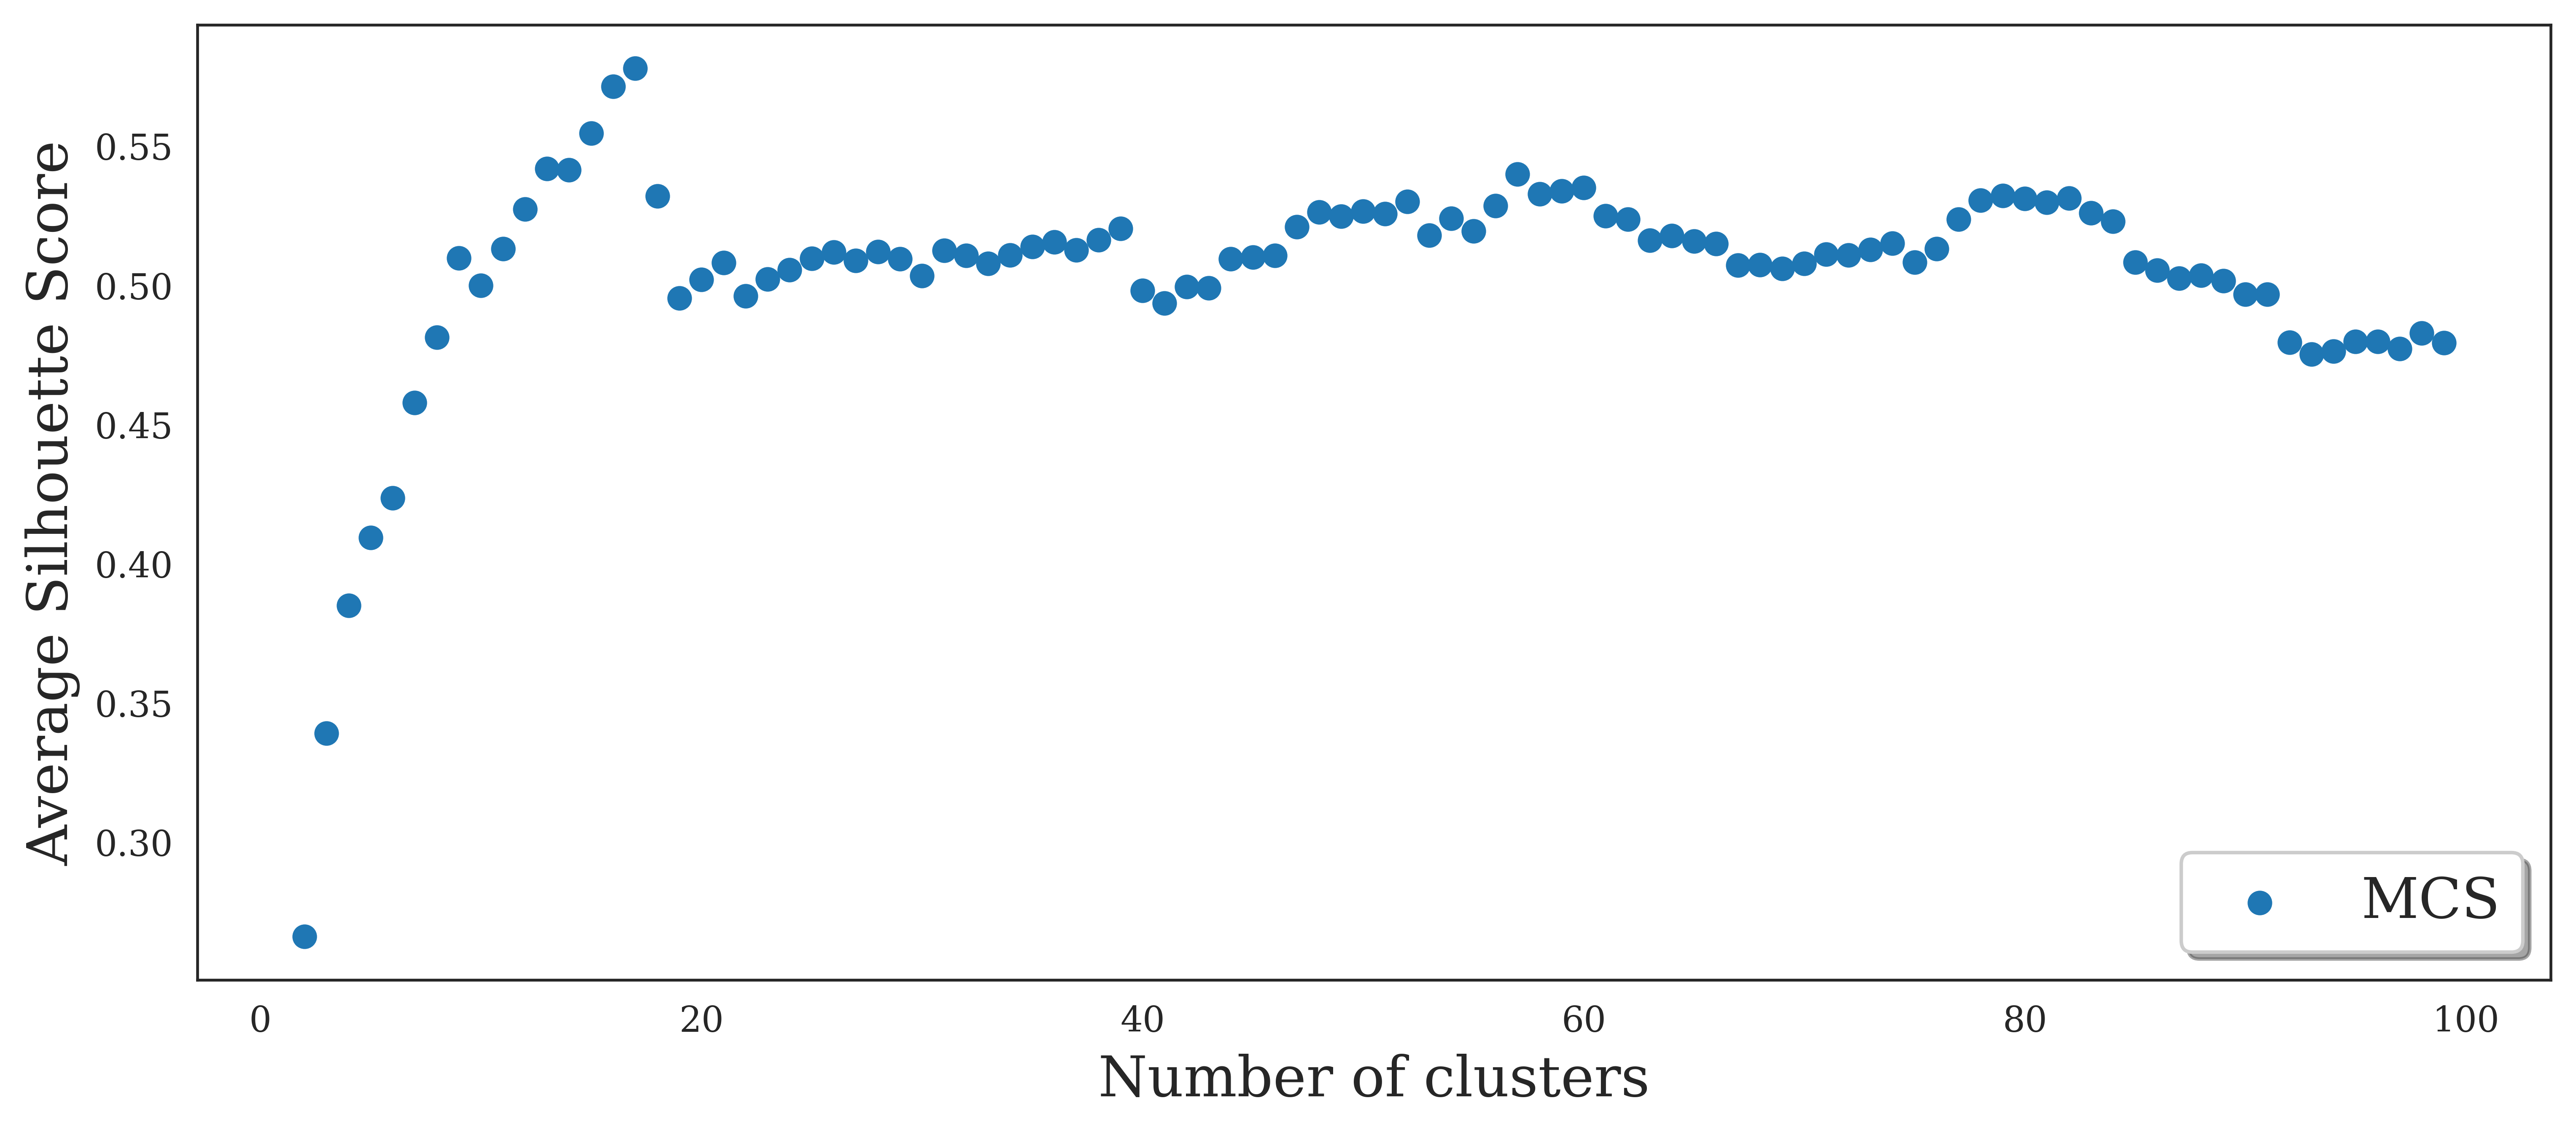

In [139]:
fig = plt.figure(figsize=(12,5), dpi = 600)
plt.rc('font', family='serif')
#plt.scatter(MACCS_K, MACCS_sil,label="MACCS")
plt.scatter(MCS_K, MCS_sil,label="MCS")
#plt.scatter(AA_MCS_K, AA_MCS_sil,label="all-atom MCS")

plt.legend()
legend = plt.legend(loc='lower right', shadow=True, fontsize=16)
plt.xlabel("Number of clusters", fontsize=16)
plt.ylabel("Average Silhouette Score", fontsize=16)
plt.show()
fig.savefig(output_path+"Silhouette analysis for determining optimal clusters K.png", bbox_inches='tight')

<Figure size 7200x18000 with 0 Axes>

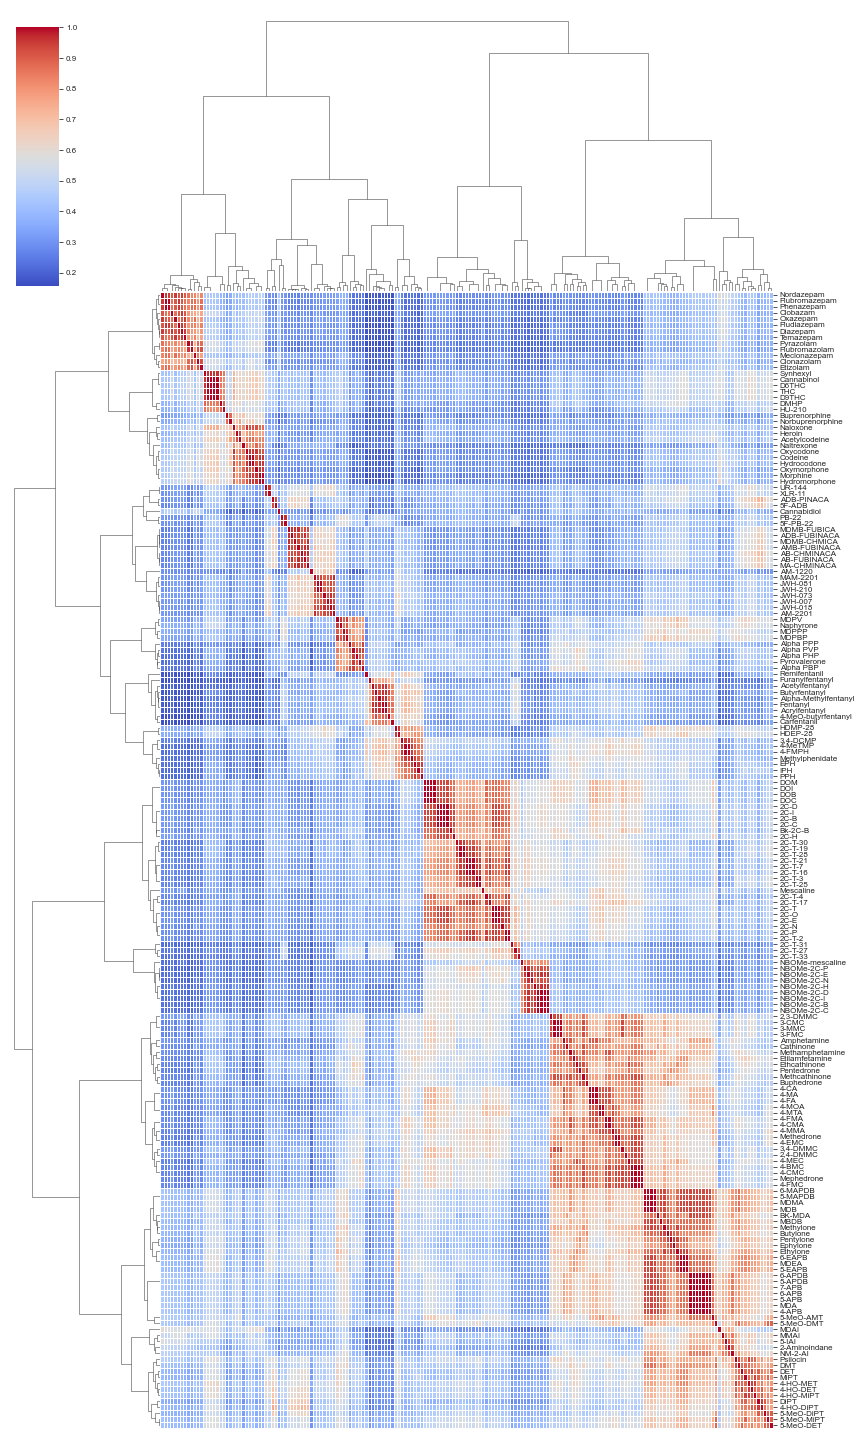

In [141]:
yticklabels= MCS.index

fig = plt.figure(figsize=(12,30), dpi = 600)
plt.rc('font', family='serif', size = 8)
sns.set_style('white')
fig = sns.clustermap(MCS_X, method='ward',cmap='coolwarm',fmt='d', linewidth=.5, xticklabels=False, yticklabels=yticklabels,figsize=(12,20))
plt.show()
fig.savefig(output_path+"Figure. Heatmap of the MCS clustering of Drug compounds.png", dpi=600,bbox_inches='tight')

##### Optimal class label K = 17 using heavy atom only MCS clustering

In [142]:
df['MCS_K']= fcluster(MCS_Z,17,criterion='maxclust')

In [143]:
df.to_csv(output_path+"Drugs Raman or SERS in literature _ Paper 1.csv",index=False)